In [1]:
import os
from PIL import Image
import time
import random
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

('2.9.2', '1.21.6')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/project

/content/drive/MyDrive/project


In [6]:
# Detection before/after
def load_image(img):
  image = Image.open(img)
  image = image.resize((256,256))
  return image


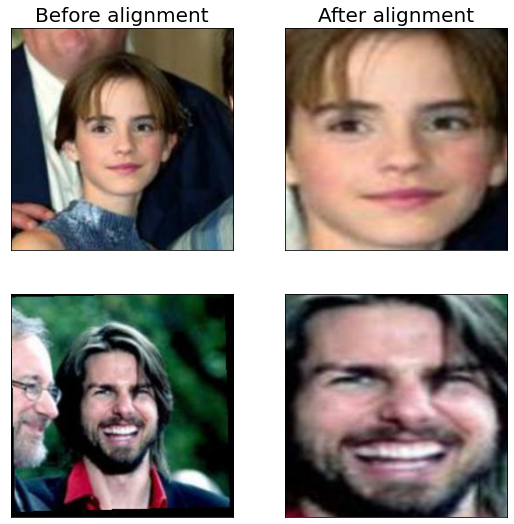

In [8]:
plt.figure(figsize=(9,9))
plt.subplot(221)
plt.title('Before alignment', size=20)
plt.ylabel('Emma watson', size=15)
plt.imshow(load_image('./lfw-deepfunneled/Emma_Watson/Emma_Watson_0001.jpg'))
plt.gca().axes.yaxis.set_visible(False)
plt.tick_params(
  axis='x',          # changes apply to the x-axis
  which='both',      # both major and minor ticks are affected
  bottom=False,      # ticks along the bottom edge are off
  top=False,         # ticks along the top edge are off
  labelbottom=False) # labels along the bottom edge are off

plt.subplot(222)
plt.title('After alignment', size=20)
plt.imshow(load_image('./lfw/Emma_Watson/1.jpg'))
plt.gca().axes.yaxis.set_visible(False)
plt.tick_params(
  axis='x',          # changes apply to the x-axis
  which='both',      # both major and minor ticks are affected
  bottom=False,      # ticks along the bottom edge are off
  top=False,         # ticks along the top edge are off
  labelbottom=False) # labels along the bottom edge are off

plt.subplot(223)
#plt.title('after alignment')
plt.ylabel('Tom cruise', size=15)
plt.imshow(load_image('./lfw-deepfunneled/Tom_Cruise/Tom_Cruise_0003.jpg'))
plt.gca().axes.yaxis.set_visible(False)
plt.tick_params(
  axis='x',          # changes apply to the x-axis
  which='both',      # both major and minor ticks are affected
  bottom=False,      # ticks along the bottom edge are off
  top=False,         # ticks along the top edge are off
  labelbottom=False) # labels along the bottom edge are off

plt.subplot(224)
#plt.title('after alignment')
plt.imshow(load_image('./lfw/Tom_Cruise/3.jpg'));
plt.gca().axes.yaxis.set_visible(False)
plt.tick_params(
  axis='x',          # changes apply to the x-axis
  which='both',      # both major and minor ticks are affected
  bottom=False,      # ticks along the bottom edge are off
  top=False,         # ticks along the top edge are off
  labelbottom=False) # labels along the bottom edge are off

5명 test data로 사용(총 20개 이미지)

- Arianna_Huffingtion
- Harry_Schmidt
- Rita_Wilson
- Ronaldo_Luis_Nazario_de_Lima
- Yevgeny_Kafelnikov


In [9]:
target_shape = (96,96)
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [11]:
def split_dataset(directory,):# split=0.9):
    folders = os.listdir(directory)
    num_train = int(len(folders))#*split)
    random.seed(42)
    random.shuffle(folders)
    
    train_list = {}#, test_list = {}, {}
    
    # Creating Train-list
    for folder in folders:#[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_list[folder] = num_files
    
    # # Creating Test-list
    # for folder in folders[num_train:]:
    #     num_files = len(os.listdir(os.path.join(directory, folder)))
    #     test_list[folder] = num_files  
    return train_list#, test_list

ROOT = './lfw'
train_list = split_dataset(ROOT)#, test_list = split_dataset(ROOT, split=0.8)
print("Length of training list:", len(train_list))
#print("Length of testing list :", len(test_list))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTrain List:", train_list)

Length of training list: 1660

Train List: {'Sarah_Hughes': 6, 'Jennifer_Thompson': 2, 'Mikulas_Dzurinda': 2, 'Tamara_Brooks': 2, 'Eric_Hinske': 2, 'Ana_Guevara': 7, 'Tracy_McGrady': 2, 'Pete_Carroll': 3, 'Susie_Castillo': 2, 'Wesley_Clark': 2, 'Bill_Belichick': 2, 'Nanni_Moretti': 2, 'Tippi_Hedren': 2, 'Roberto_Marinho': 3, 'Saparmurat_Niyazov': 2, 'Kim_Ryong-sung': 11, 'Vicente_Fox': 32, 'Barbra_Streisand': 3, 'Paul_Sarbanes': 3, 'JK_Rowling': 6, 'Kalpana_Chawla': 5, 'Rick_Stansbury': 3, 'Mark_Hurlbert': 5, 'Ricardo_Sanchez': 6, 'Magdalena_Maleeva': 3, 'Frank_Lautenberg': 2, 'Mark_Richt': 3, 'Arsinee_Khanjian': 2, 'Chris_Bell': 2, 'Amber_Tamblyn': 2, 'Harbhajan_Singh': 2, 'Max_Mayfield': 2, 'Sheila_Wellstone': 2, 'Victoria_Beckham': 3, 'John_Taylor': 2, 'Carlos_Quintanilla_Schmidt': 2, 'Ari_Fleischer': 13, 'Paul_Bremer': 20, 'Robbie_Williams': 3, 'George_Ryan': 4, 'Ana_Palacio': 8, 'John_Stockton': 5, 'Sam_Bith': 3, 'Alexandra_Vodjanikova': 2, 'Lindsay_Davenport': 22, 'Gian_Marco': 3

In [12]:
sum(train_list.values())

9048

In [13]:
def create_triplets(directory, folder_list, max_files=15):
    triplets = []
    folders = list(folder_list.keys())
    
    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)
        
        for i in range(1, num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, f"{files[i]}")
                positive = (folder, f"{files[j]}")

                neg_folder = folder
                while neg_folder == folder:
                    
                    neg_folder = random.choice(folders)
                img_list = os.listdir(os.path.join(ROOT, neg_folder))
                neg_file = random.randint(1, folder_list[neg_folder]-1)
                negative = (neg_folder, f"{img_list[neg_file]}")

                triplets.append((anchor, positive, negative))   
    random.shuffle(triplets)
    return triplets

In [14]:
train_triplet = create_triplets(ROOT, train_list)
#test_triplet  = create_triplets(ROOT, test_list)

print("Number of training triplets:", len(train_triplet))
#print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 15988

Examples of triplets:
(('Adrien_Brody', '11.jpg'), ('Adrien_Brody', '12.jpg'), ('Hitomi_Soga', '5.jpg'))
(('Atal_Bihari_Vajpayee', '9.jpg'), ('Atal_Bihari_Vajpayee', '10.jpg'), ('Kelvin_Sampson', '3.jpg'))
(('Jennifer_Aniston', '11.jpg'), ('Jennifer_Aniston', '15.jpg'), ('Mahmoud_Abbas', '16.jpg'))
(('Naji_Sabri', '3.jpg'), ('Naji_Sabri', '6.jpg'), ('Tim_Duncan', '4.jpg'))
(('Ralf_Schumacher', '2.jpg'), ('Ralf_Schumacher', '7.jpg'), ('Sean_Penn', '3.jpg'))


15988

In [15]:
anchor = []
positive = []
negative = []
for i in range(len(train_triplet)):
  anchor.append(os.path.join(ROOT, train_triplet[i][0][0], train_triplet[i][0][1]))
  positive.append(os.path.join(ROOT, train_triplet[i][1][0], train_triplet[i][1][1]))
  negative.append(os.path.join(ROOT, train_triplet[i][2][0], train_triplet[i][2][1]))


In [16]:
train_triplet[0]

(('Adrien_Brody', '11.jpg'),
 ('Adrien_Brody', '12.jpg'),
 ('Hitomi_Soga', '5.jpg'))

In [17]:
anchor[0], positive[0], negative[0]

('./lfw/Adrien_Brody/11.jpg',
 './lfw/Adrien_Brody/12.jpg',
 './lfw/Hitomi_Soga/5.jpg')

In [19]:
# We need to make sure both the anchor and positive images are loaded in
# sorted order so we can match them together.
anchor_images = anchor

positive_images = positive

negative_images = negative

image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)

# To generate the list of negative images, let's randomize the list of
# available images and concatenate them together.
# rng = np.random.RandomState(seed=42)
# rng.shuffle(anchor_images)
# rng.shuffle(positive_images)
# rng.shuffle(negative_images)

# negative_images = anchor_images + positive_images
# np.random.RandomState(seed=32).shuffle(negative_images)

# negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
# negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

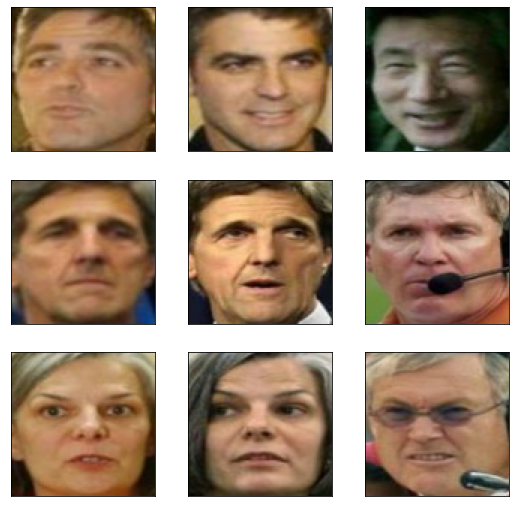

In [20]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

## Training model

In [23]:
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
# def get_encoder(input_shape):
#     """ Returns the image encoding model """

#     pretrained_model = Xception(
#         input_shape=input_shape,
#         weights='imagenet',
#         include_top=False,
#         pooling='avg',
#     )
    
#     for i in range(len(pretrained_model.layers)-27):
#         pretrained_model.layers[i].trainable = False

#     encode_model = Sequential([
#         pretrained_model,
#         layers.Flatten(),
#         layers.Dense(512, activation='relu'),
#         layers.BatchNormalization(),
#         layers.Dense(256, activation="relu"),
#         layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
#     ], name="Encode_Model")
#     return encode_model

In [21]:
from model import create_model

encoder = create_model()
encoder.load_weights('nn4weights/nn4.small2.v1.h5')

In [24]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def get_siamese_network(input_shape = (96, 96, 3)):
    #encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Positive_Input (InputLayer)    [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Negative_Input (InputLayer)    [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128)          3743280     ['Anchor_Input[0][0]',           
                                                                  'Positive_Input[0]

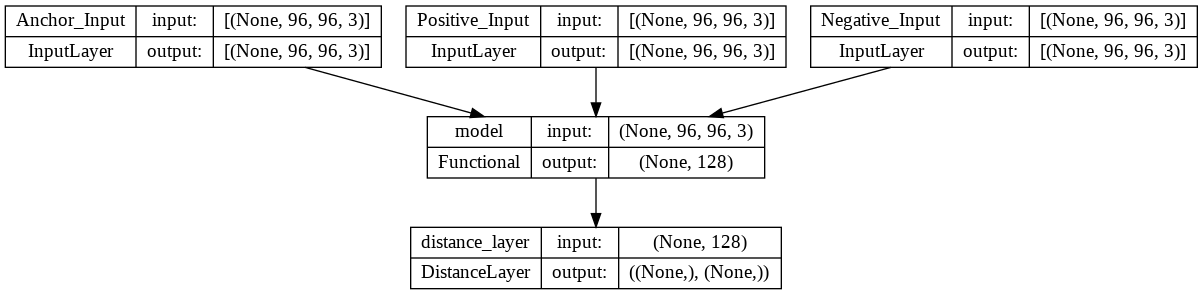

In [25]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

In [26]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        #evaluate()
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
        #return self.loss_tracker.result()

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [27]:
siamese_model = SiameseModel(siamese_network, margin=1.0)
optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)


In [28]:
from keras.callbacks import ModelCheckpoint

checkpoint_path = './lfw-3_weights/'#{epoch:02d}.ckpt'
os.makedirs(checkpoint_path, exist_ok=True)


checkpoint = ModelCheckpoint(
    filepath = checkpoint_path+'/checkpoint.ckpt', monitor='val_loss', verbose=1,
    save_best_only=True, mode='min', save_weights_only=True
)
with tf.device('/gpu:0'):
  history = siamese_model.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=[checkpoint])
siamese_model.save_weights(f'{checkpoint_path}/final.ckpt')

Epoch 1/30
400/400 [==============================] - ETA: 0s - loss: 0.2699


Epoch 1: val_loss improved from inf to 0.16864, saving model to ./drive/MyDrive/project/lfw-3_weights/checkpoint.ckpt
400/400 [==============================] - 1018s 2s/step - loss: 0.2699 - val_loss: 0.1686
Epoch 2/30
400/400 [==============================] - ETA: 0s - loss: 0.1176


Epoch 2: val_loss improved from 0.16864 to 0.11212, saving model to ./drive/MyDrive/project/lfw-3_weights/checkpoint.ckpt
400/400 [==============================] - 77s 193ms/step - loss: 0.1176 - val_loss: 0.1121
Epoch 3/30
400/400 [==============================] - ETA: 0s - loss: 0.0722


Epoch 3: val_loss improved from 0.11212 to 0.08999, saving model to ./drive/MyDrive/project/lfw-3_weights/checkpoint.ckpt
400/400 [==============================] - 77s 193ms/step - loss: 0.0722 - val_loss: 0.0900
Epoch 4/30
400/400 [==============================] - ETA: 0s - loss: 0.0457


Epoch 4: val_loss improved from 0.08999 to 0.08081, saving model to ./drive/MyDrive/project/lfw-3_weights/checkpoint.ckpt
400/400 [==============================] - 77s 192ms/step - loss: 0.0457 - val_loss: 0.0808
Epoch 5/30
400/400 [==============================] - ETA: 0s - loss: 0.0314


Epoch 5: val_loss improved from 0.08081 to 0.06994, saving model to ./drive/MyDrive/project/lfw-3_weights/checkpoint.ckpt
400/400 [==============================] - 78s 195ms/step - loss: 0.0314 - val_loss: 0.0699
Epoch 6/30
400/400 [==============================] - ETA: 0s - loss: 0.0206


Epoch 6: val_loss improved from 0.06994 to 0.06532, saving model to ./drive/MyDrive/project/lfw-3_weights/checkpoint.ckpt
400/400 [==============================] - 78s 195ms/step - loss: 0.0206 - val_loss: 0.0653
Epoch 7/30
400/400 [==============================] - ETA: 0s - loss: 0.0157


Epoch 7: val_loss improved from 0.06532 to 0.06388, saving model to ./drive/MyDrive/project/lfw-3_weights/checkpoint.ckpt
400/400 [==============================] - 77s 193ms/step - loss: 0.0157 - val_loss: 0.0639
Epoch 8/30
400/400 [==============================] - ETA: 0s - loss: 0.0137


Epoch 8: val_loss did not improve from 0.06388
400/400 [==============================] - 76s 191ms/step - loss: 0.0137 - val_loss: 0.0677
Epoch 9/30
400/400 [==============================] - ETA: 0s - loss: 0.0092


Epoch 9: val_loss improved from 0.06388 to 0.05670, saving model to ./drive/MyDrive/project/lfw-3_weights/checkpoint.ckpt
400/400 [==============================] - 77s 194ms/step - loss: 0.0092 - val_loss: 0.0567
Epoch 10/30
400/400 [==============================] - ETA: 0s - loss: 0.0060


Epoch 10: val_loss improved from 0.05670 to 0.05177, saving model to ./drive/MyDrive/project/lfw-3_weights/checkpoint.ckpt
400/400 [==============================] - 77s 193ms/step - loss: 0.0060 - val_loss: 0.0518
Epoch 11/30
400/400 [==============================] - ETA: 0s - loss: 0.0054


Epoch 11: val_loss improved from 0.05177 to 0.05056, saving model to ./drive/MyDrive/project/lfw-3_weights/checkpoint.ckpt
400/400 [==============================] - 77s 192ms/step - loss: 0.0054 - val_loss: 0.0506
Epoch 12/30
400/400 [==============================] - ETA: 0s - loss: 0.0042


Epoch 12: val_loss improved from 0.05056 to 0.04577, saving model to ./drive/MyDrive/project/lfw-3_weights/checkpoint.ckpt
400/400 [==============================] - 77s 192ms/step - loss: 0.0042 - val_loss: 0.0458
Epoch 13/30
400/400 [==============================] - ETA: 0s - loss: 0.0040


Epoch 13: val_loss did not improve from 0.04577
400/400 [==============================] - 76s 191ms/step - loss: 0.0040 - val_loss: 0.0515
Epoch 14/30
400/400 [==============================] - ETA: 0s - loss: 0.0032


Epoch 14: val_loss did not improve from 0.04577
400/400 [==============================] - 77s 192ms/step - loss: 0.0032 - val_loss: 0.0492
Epoch 15/30
400/400 [==============================] - ETA: 0s - loss: 0.0030


Epoch 15: val_loss did not improve from 0.04577
400/400 [==============================] - 77s 191ms/step - loss: 0.0030 - val_loss: 0.0505
Epoch 16/30
400/400 [==============================] - ETA: 0s - loss: 0.0029


Epoch 16: val_loss improved from 0.04577 to 0.04435, saving model to ./drive/MyDrive/project/lfw-3_weights/checkpoint.ckpt
400/400 [==============================] - 77s 192ms/step - loss: 0.0029 - val_loss: 0.0443
Epoch 17/30
400/400 [==============================] - ETA: 0s - loss: 0.0019


Epoch 17: val_loss did not improve from 0.04435
400/400 [==============================] - 76s 191ms/step - loss: 0.0019 - val_loss: 0.0463
Epoch 18/30
400/400 [==============================] - ETA: 0s - loss: 0.0020


Epoch 18: val_loss did not improve from 0.04435
400/400 [==============================] - 77s 191ms/step - loss: 0.0020 - val_loss: 0.0466
Epoch 19/30
400/400 [==============================] - ETA: 0s - loss: 0.0016


Epoch 19: val_loss improved from 0.04435 to 0.04152, saving model to ./drive/MyDrive/project/lfw-3_weights/checkpoint.ckpt
400/400 [==============================] - 77s 193ms/step - loss: 0.0016 - val_loss: 0.0415
Epoch 20/30
400/400 [==============================] - ETA: 0s - loss: 0.0012


Epoch 20: val_loss did not improve from 0.04152
400/400 [==============================] - 77s 191ms/step - loss: 0.0012 - val_loss: 0.0463
Epoch 21/30
400/400 [==============================] - ETA: 0s - loss: 0.0014


Epoch 21: val_loss did not improve from 0.04152
400/400 [==============================] - 76s 191ms/step - loss: 0.0014 - val_loss: 0.0432
Epoch 22/30
400/400 [==============================] - ETA: 0s - loss: 0.0012


Epoch 22: val_loss did not improve from 0.04152
400/400 [==============================] - 77s 192ms/step - loss: 0.0012 - val_loss: 0.0437
Epoch 23/30
400/400 [==============================] - ETA: 0s - loss: 0.0011


Epoch 23: val_loss did not improve from 0.04152
400/400 [==============================] - 76s 191ms/step - loss: 0.0011 - val_loss: 0.0416
Epoch 24/30
400/400 [==============================] - ETA: 0s - loss: 0.0012


Epoch 24: val_loss did not improve from 0.04152
400/400 [==============================] - 77s 191ms/step - loss: 0.0012 - val_loss: 0.0471
Epoch 25/30
400/400 [==============================] - ETA: 0s - loss: 0.0015


Epoch 25: val_loss did not improve from 0.04152
400/400 [==============================] - 78s 194ms/step - loss: 0.0015 - val_loss: 0.0423
Epoch 26/30
400/400 [==============================] - ETA: 0s - loss: 0.0010


Epoch 26: val_loss improved from 0.04152 to 0.04031, saving model to ./drive/MyDrive/project/lfw-3_weights/checkpoint.ckpt
400/400 [==============================] - 78s 195ms/step - loss: 0.0010 - val_loss: 0.0403
Epoch 27/30
400/400 [==============================] - ETA: 0s - loss: 8.0963e-04


Epoch 27: val_loss did not improve from 0.04031
400/400 [==============================] - 77s 193ms/step - loss: 8.0963e-04 - val_loss: 0.0416
Epoch 28/30
400/400 [==============================] - ETA: 0s - loss: 6.0142e-04


Epoch 28: val_loss improved from 0.04031 to 0.03940, saving model to ./drive/MyDrive/project/lfw-3_weights/checkpoint.ckpt
400/400 [==============================] - 77s 192ms/step - loss: 6.0142e-04 - val_loss: 0.0394
Epoch 29/30
400/400 [==============================] - ETA: 0s - loss: 7.5099e-04


Epoch 29: val_loss did not improve from 0.03940
400/400 [==============================] - 77s 193ms/step - loss: 7.5099e-04 - val_loss: 0.0429
Epoch 30/30
400/400 [==============================] - ETA: 0s - loss: 0.0010


Epoch 30: val_loss did not improve from 0.03940
400/400 [==============================] - 76s 191ms/step - loss: 0.0010 - val_loss: 0.0426


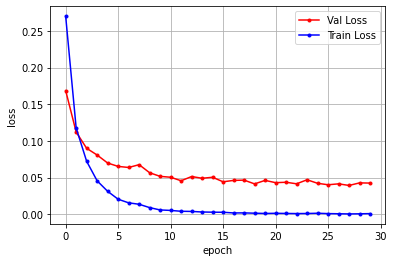

In [29]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Val Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [32]:
checkpoint_path = './drive/MyDrive/project/lfw-3_weights'
siamese_model.load_weights(f'{checkpoint_path}/checkpoint.ckpt')

## Result

In [33]:
def extract_encoder(model):
    encoder = create_model()
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
#encoder.save_weights("encoder-lfw_margin0")
encoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 zero_padding2d_23 (ZeroPadding  (None, 102, 102, 3)  0          ['input_2[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv1 (Conv2D)                 (None, 48, 48, 64)   9472        ['zero_padding2d_23[0][0]']      
                                                                                                  
 bn1 (BatchNormalization)       (None, 48, 48, 64)   256         ['conv1[0][0]']            

In [34]:
# https://github.com/krasserm/face-recognition/blob/master/face-recognition.ipynb

import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in sorted(os.listdir(path)):
        for f in sorted(os.listdir(os.path.join(path, i))):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('lfw_test')

In [ ]:
# 인물당 5장씩 총 100장
for img in metadata:
  print(img.image_path())

lfw_test/Allyson_Felix/1.jpg
lfw_test/Allyson_Felix/2.jpg
lfw_test/Allyson_Felix/3.jpg
lfw_test/Allyson_Felix/4.jpg
lfw_test/Allyson_Felix/5.jpg
lfw_test/Antonio_Banderas/1.jpg
lfw_test/Antonio_Banderas/2.jpg
lfw_test/Antonio_Banderas/3.jpg
lfw_test/Antonio_Banderas/4.jpg
lfw_test/Antonio_Banderas/5.jpg
lfw_test/Ashanti/1.jpg
lfw_test/Ashanti/2.jpg
lfw_test/Ashanti/3.jpg
lfw_test/Ashanti/4.jpg
lfw_test/Ashanti/5.jpg
lfw_test/Cruz_Bustamante/1.jpg
lfw_test/Cruz_Bustamante/2.jpg
lfw_test/Cruz_Bustamante/3.jpg
lfw_test/Cruz_Bustamante/4.jpg
lfw_test/Cruz_Bustamante/5.jpg
lfw_test/Hal_Gehman/1.jpg
lfw_test/Hal_Gehman/2.jpg
lfw_test/Hal_Gehman/3.jpg
lfw_test/Hal_Gehman/4.jpg
lfw_test/Hal_Gehman/5.jpg
lfw_test/Heidi_Klum/1.jpg
lfw_test/Heidi_Klum/2.jpg
lfw_test/Heidi_Klum/3.jpg
lfw_test/Heidi_Klum/4.jpg
lfw_test/Heidi_Klum/5.jpg
lfw_test/Jake_Gyllenhaal/1.jpg
lfw_test/Jake_Gyllenhaal/2.jpg
lfw_test/Jake_Gyllenhaal/3.jpg
lfw_test/Jake_Gyllenhaal/4.jpg
lfw_test/Jake_Gyllenhaal/5.jpg
lfw_test/L

In [35]:
# https://keras.io/examples/vision/siamese_network/
    
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)

    #Converting integer types to floating point types returns normalized floating point values in the range [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)

    image = tf.image.resize(image,(96,96))

    image = tf.expand_dims(image, axis=0)
   
    return image

In [36]:
# https://github.com/krasserm/face-recognition/blob/master/face-recognition.ipynb

embedded = np.zeros((metadata.shape[0], 128))

for i, m in enumerate(metadata):
    #align_mtcnn.get_aligned_face의 output은 image > array 형식으로 변환
    img = preprocess_image(m.image_path())
   
    # obtain embedding vector for image
    embedded[i] = encoder.predict(img, verbose=0)[0]

- 동일인물

In [37]:
# https://github.com/krasserm/face-recognition/blob/master/face-recognition.ipynb

def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.xlabel(metadata[idx1].image_path().split('/')[1])
    plt.gca().axes.yaxis.set_visible(False)
    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='both',      # both major and minor ticks are affected
      bottom=False,      # ticks along the bottom edge are off
      top=False,         # ticks along the top edge are off
      labelbottom=False) # labels along the bottom edge are off
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()))
    plt.xlabel(metadata[idx2].image_path().split('/')[1])
    plt.gca().axes.yaxis.set_visible(False)
    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='both',      # both major and minor ticks are affected
      bottom=False,      # ticks along the bottom edge are off
      top=False,         # ticks along the top edge are off
      labelbottom=False) # labels along the bottom edge are off

i=0
for _ in range(20):
  show_pair(0+i,1+i)
  i+=5

Output hidden; open in https://colab.research.google.com to view.

- 다른 인물

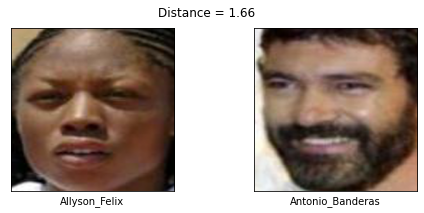

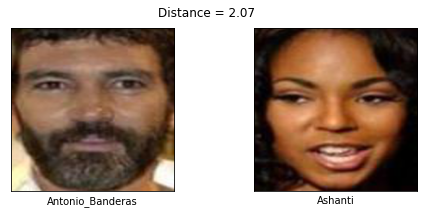

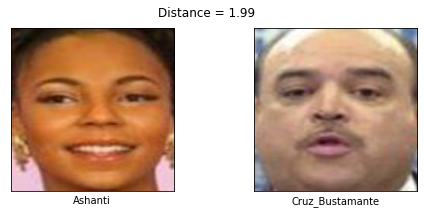

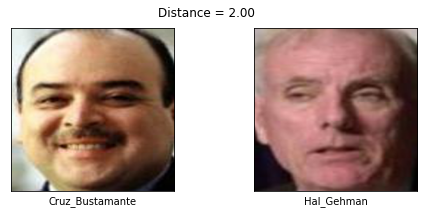

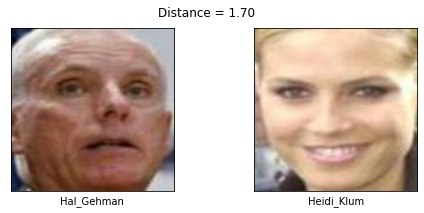

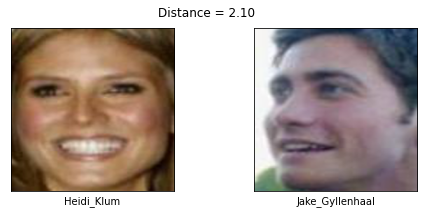

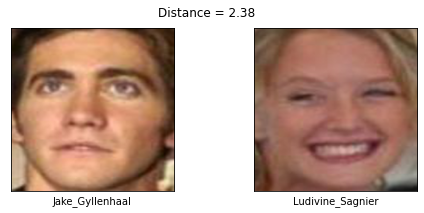

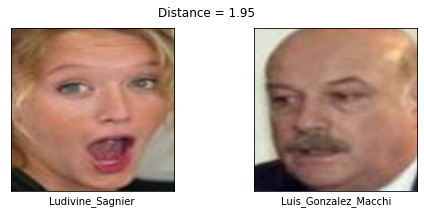

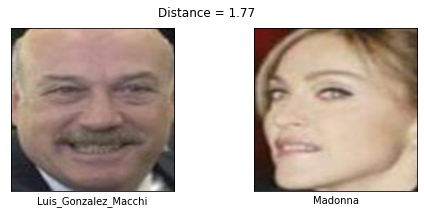

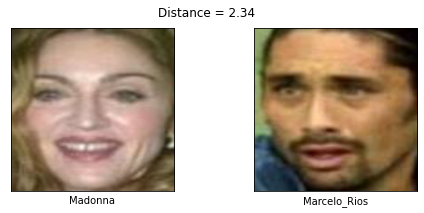

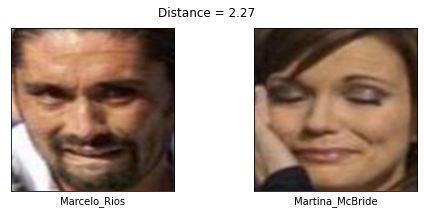

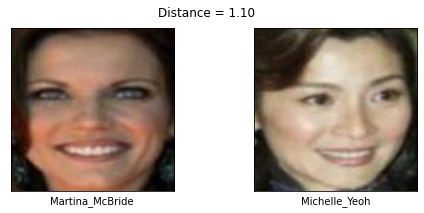

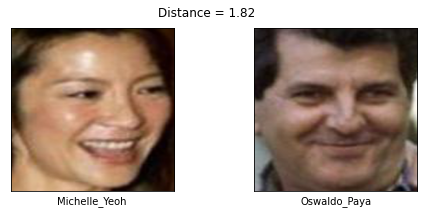

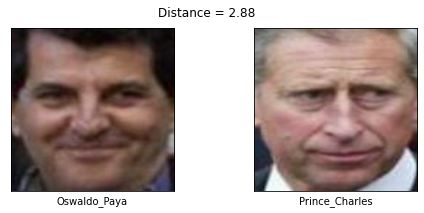

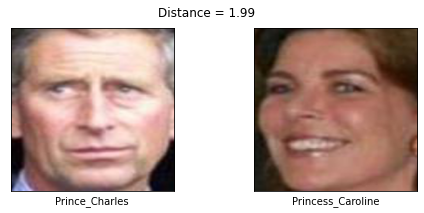

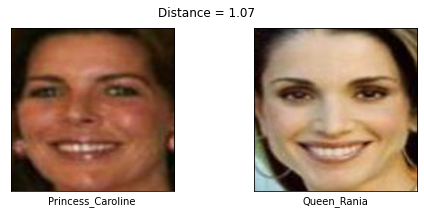

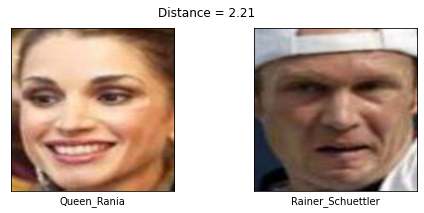

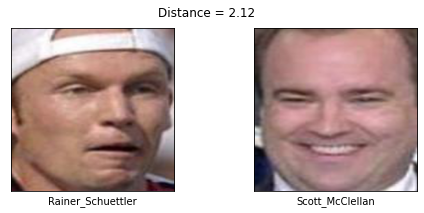

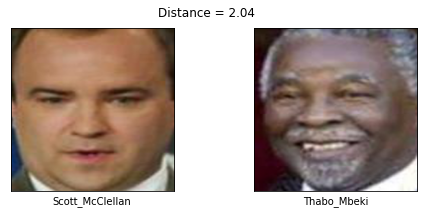

In [38]:
# https://github.com/krasserm/face-recognition/blob/master/face-recognition.ipynb

def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.xlabel(metadata[idx1].image_path().split('/')[1])
    plt.gca().axes.yaxis.set_visible(False)
    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='both',      # both major and minor ticks are affected
      bottom=False,      # ticks along the bottom edge are off
      top=False,         # ticks along the top edge are off
      labelbottom=False) # labels along the bottom edge are off
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()))
    plt.xlabel(metadata[idx2].image_path().split('/')[1])
    plt.gca().axes.yaxis.set_visible(False)
    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='both',      # both major and minor ticks are affected
      bottom=False,      # ticks along the bottom edge are off
      top=False,         # ticks along the top edge are off
      labelbottom=False) # labels along the bottom edge are off

i=0
for _ in range(19):
  show_pair(0+i,6+i)
  i+=5

### distance threshold를 0.75로 설정 

*   accuracy : 약 0.895 
*   f1 score : 약 0.63


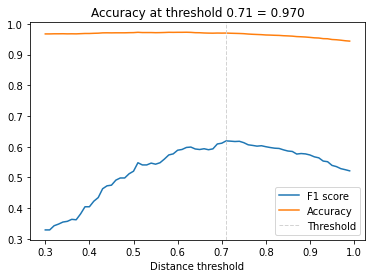

In [39]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(i + 1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();


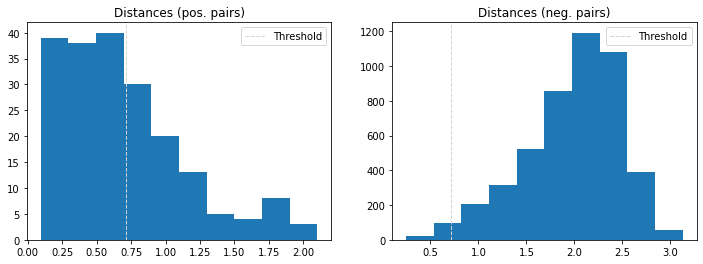

In [40]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

## 인물 예측
 - KNN, SVM이외 모델 사용가능

In [50]:
def extract_encoder(model):
    encoder = create_model()
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
#encoder.save_weights("encoder-lfw_margin0")
encoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 zero_padding2d_69 (ZeroPadding  (None, 102, 102, 3)  0          ['input_4[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv1 (Conv2D)                 (None, 48, 48, 64)   9472        ['zero_padding2d_69[0][0]']      
                                                                                                  
 bn1 (BatchNormalization)       (None, 48, 48, 64)   256         ['conv1[0][0]']            

In [51]:
train_idx = np.arange(metadata.shape[0]) % 2 == 0
test_idx = np.arange(metadata.shape[0]) % 2 != 0
test_list = metadata[test_idx]
name_list = []
delidx = []
for i,name in enumerate(test_list):
  if name.image_path().split('/')[-2] in name_list:
    #test_list = np.delete(test_list, i)
    delidx.append(i)
    name_list.append(name.image_path().split('/')[-2])
  else:
    name_list.append(name.image_path().split('/')[-2])
#test_list =  [item for item in test_list if item.image_path().split('/')[-2]=='0']
#test_list
#test_list = [item for item in test_list if item.image_path().split('_')[-2]=='0']
test_list

array([lfw_test/Allyson_Felix/2.jpg, lfw_test/Allyson_Felix/4.jpg,
       lfw_test/Antonio_Banderas/1.jpg, lfw_test/Antonio_Banderas/3.jpg,
       lfw_test/Antonio_Banderas/5.jpg, lfw_test/Ashanti/2.jpg,
       lfw_test/Ashanti/4.jpg, lfw_test/Cruz_Bustamante/1.jpg,
       lfw_test/Cruz_Bustamante/3.jpg, lfw_test/Cruz_Bustamante/5.jpg,
       lfw_test/Hal_Gehman/2.jpg, lfw_test/Hal_Gehman/4.jpg,
       lfw_test/Heidi_Klum/1.jpg, lfw_test/Heidi_Klum/3.jpg,
       lfw_test/Heidi_Klum/5.jpg, lfw_test/Jake_Gyllenhaal/2.jpg,
       lfw_test/Jake_Gyllenhaal/4.jpg, lfw_test/Ludivine_Sagnier/1.jpg,
       lfw_test/Ludivine_Sagnier/3.jpg, lfw_test/Ludivine_Sagnier/5.jpg,
       lfw_test/Luis_Gonzalez_Macchi/2.jpg,
       lfw_test/Luis_Gonzalez_Macchi/4.jpg, lfw_test/Madonna/1.jpg,
       lfw_test/Madonna/3.jpg, lfw_test/Madonna/5.jpg,
       lfw_test/Marcelo_Rios/2.jpg, lfw_test/Marcelo_Rios/4.jpg,
       lfw_test/Martina_McBride/1.jpg, lfw_test/Martina_McBride/3.jpg,
       lfw_test/Martina_Mc

In [52]:
test_list = np.delete(test_list,delidx);test_list

array([lfw_test/Allyson_Felix/2.jpg, lfw_test/Antonio_Banderas/1.jpg,
       lfw_test/Ashanti/2.jpg, lfw_test/Cruz_Bustamante/1.jpg,
       lfw_test/Hal_Gehman/2.jpg, lfw_test/Heidi_Klum/1.jpg,
       lfw_test/Jake_Gyllenhaal/2.jpg, lfw_test/Ludivine_Sagnier/1.jpg,
       lfw_test/Luis_Gonzalez_Macchi/2.jpg, lfw_test/Madonna/1.jpg,
       lfw_test/Marcelo_Rios/2.jpg, lfw_test/Martina_McBride/1.jpg,
       lfw_test/Michelle_Yeoh/2.jpg, lfw_test/Oswaldo_Paya/1.jpg,
       lfw_test/Prince_Charles/2.jpg, lfw_test/Princess_Caroline/1.jpg,
       lfw_test/Queen_Rania/2.jpg, lfw_test/Rainer_Schuettler/1.jpg,
       lfw_test/Scott_McClellan/2.jpg, lfw_test/Thabo_Mbeki/1.jpg],
      dtype=object)

In [53]:
# https://github.com/krasserm/face-recognition/blob/master/face-recognition.ipynb

test_embedded = np.zeros((len(test_list), 128))

for i, m in enumerate(test_list):
    #align_mtcnn.get_aligned_face의 output은 image > array 형식으로 변환
    img = preprocess_image(m.image_path())
   
    # obtain embedding vector for image
    test_embedded[i] = encoder.predict(img, verbose=0)[0]

In [54]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) % 2 == 0
test_idx = np.arange(metadata.shape[0]) % 2 != 0

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()
rfc = RandomForestClassifier(random_state=0)

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)
rfc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))
acc_rfc = accuracy_score(y_test, rfc.predict(X_test))

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}, RF accuracy = {acc_rfc}')


KNN accuracy = 0.82, SVM accuracy = 0.76, RF accuracy = 0.76


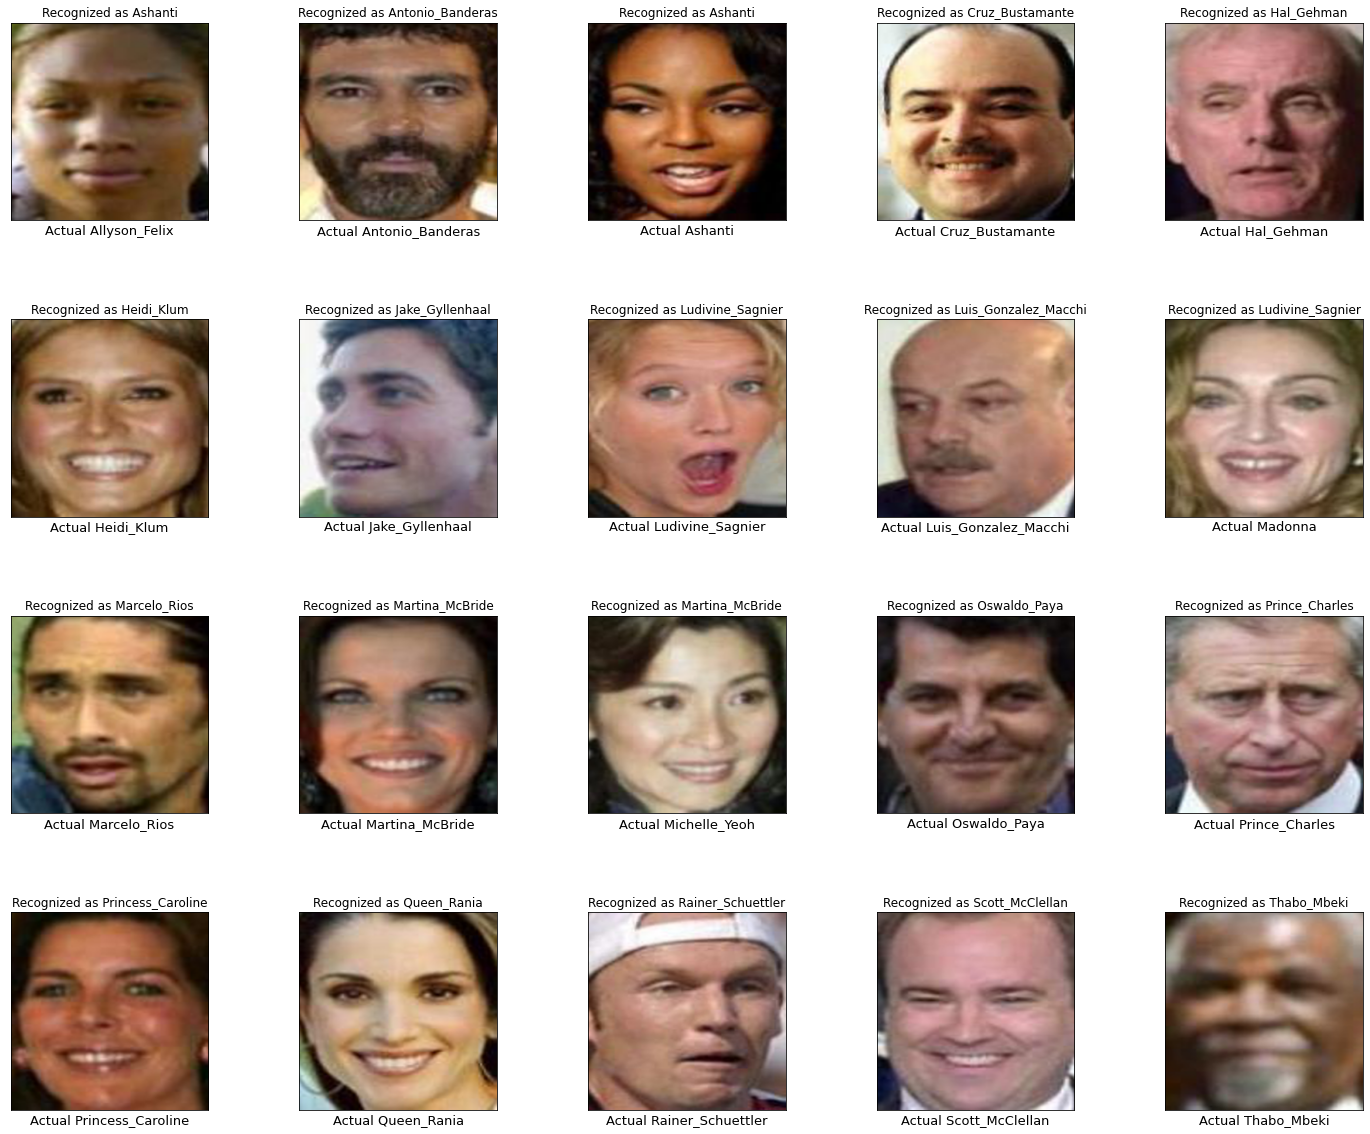

In [55]:
# 20명중 17명 85%

fig = plt.figure(figsize=(25,20))
#fig.subplots_adjust(hspace=1)
for i in range(1,21):
  plt.subplot(4,5,i)
  plt.subplots_adjust(hspace=0.5)
  example_image = load_image(test_list[i-1].image_path())
  example_prediction = knn.predict([test_embedded[i-1]])
  example_identity = encoder.inverse_transform(example_prediction)[0]
  plt.imshow(example_image)
  #plt.gca().axes.xaxis.set_visible(False)
  plt.gca().axes.yaxis.set_visible(False)
  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
  plt.title(f'Recognized as {example_identity}');
  plt.xlabel(f'Actual {test_list[i-1].image_path().split("/")[-2]}',size=13)